In [1]:
import numpy as np

import matplotlib.pyplot as plt

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score

import torch
import torch.nn
import torch.optim
import torch.utils.data

import time
import math

In [2]:
import importlib
import LearningCutsUtils
import LearningCutsUtils.Utils as LCU
## needed if we change LearningCutsUtils and want to avoid reloading the kernel to see the effects
importlib.reload(LearningCutsUtils.Utils)

<module 'LearningCutsUtils.Utils' from '/home/mhance/CABIN/LearningCutsUtils/Utils.py'>

In [3]:
from LearningCutsUtils import OneToOneLinear, EfficiencyScanNetwork
from LearningCutsUtils import loss_fn, effic_loss_fn, lossvars


In [4]:
N=20000 # number of points
m=10 # dimensions

In [5]:
# array of means and widths for gaussians,
# indices are:
# - number of dimensions
# - signal (0) vs background (1)
# - mean (0) vs width (1)

np.random.seed(123)
width_scale_factor=2.
mean_scale_factor=1.

# if we want more control over the function, for example
means_widths=[[[4,0.4],
               [-2,.10]],
              [[3,1.0],
               [-1,0.5]]]

means_widths=np.random.randn(m,2,2)               

# now construct the training data.  after taking transpose, should be N rows by m columns.  
x_signal=np.array([mean_scale_factor*means_widths[i][0][0]+width_scale_factor*np.fabs(means_widths[i][0][1])*np.random.randn(N) for i in range(m)]).T
y_signal=np.ones(N)
x_backgr=np.array([mean_scale_factor*means_widths[i][1][0]+width_scale_factor*np.fabs(means_widths[i][1][1])*np.random.randn(N) for i in range(m)]).T
y_backgr=np.zeros(N)
x=np.concatenate((x_signal,x_backgr))
y=np.concatenate((y_signal,y_backgr))

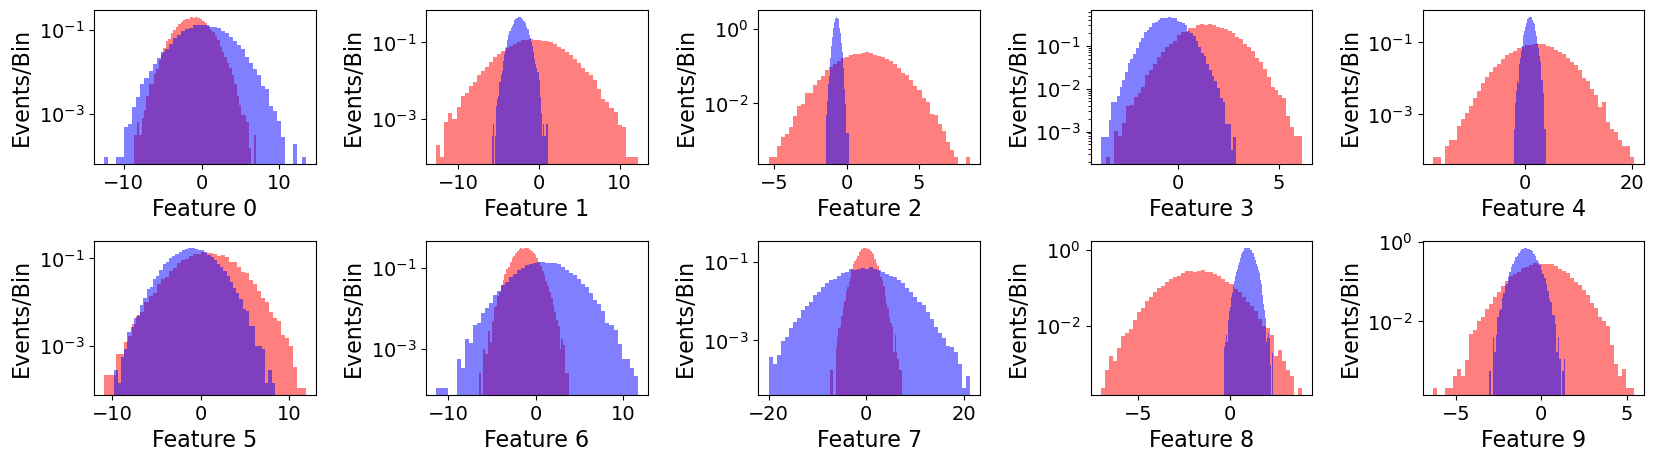

In [20]:
fig = plt.figure(figsize=(20,5))
fig.tight_layout()
nbins=50

for b in range(m):
    ax=fig.add_subplot(2,5,1+b)
    plt.subplots_adjust(hspace=0.5,wspace=0.5)
    plt.yscale('log')
    ax.hist(x_signal[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='red')
    ax.hist(x_backgr[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='blue')
    ax.set_xlabel(f"Feature {b}")
    ax.set_ylabel("Events/Bin")
    plt.savefig("features_dummy.pdf")

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

sc = StandardScaler()
x_train_scaled = sc.fit_transform(x_train)
x_test_scaled  = sc.transform(x_test)

In [8]:
x_train_tensor=torch.tensor(x_train_scaled,dtype=torch.float)
y_train_tensor=torch.tensor(y_train,dtype=torch.float)

x_test_tensor=torch.tensor(x_test_scaled,dtype=torch.float)
y_test_tensor=torch.tensor(y_test,dtype=torch.float)

In [9]:
# some hyperparameters
learning_rate=0.5
batch_size=int(len(y_train)/1.) # only one batch
epochs=100

In [10]:
torch.manual_seed(123)

net = torch.nn.Sequential(
    torch.nn.Linear(m, 1,bias=False),
    torch.nn.Sigmoid()
)

torch.save(net.state_dict(), 'net_FC_untrained.pth')
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

In [11]:
losses = []
losses_test = []

net.load_state_dict(torch.load('net_FC_untrained.pth',weights_only=True))

xy_train = torch.utils.data.TensorDataset(x_train_tensor.float(),y_train_tensor)
loader = torch.utils.data.DataLoader(xy_train, batch_size=batch_size, shuffle=True)

debug=False

for epoch in range(epochs):
    net.train()
    start_time = time.time()
    for x_batch, y_batch in loader:
        
        y_pred = net(x_batch).squeeze(1)
        optimizer.zero_grad()
        loss = torch.nn.BCELoss()(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        
    losses.append(loss.data)

    # configure the model for evaluation (testing)
    net.eval()
    
    y_pred = net(x_test_tensor).squeeze(1)
    test_loss = torch.nn.BCELoss()(y_pred, y_test_tensor)
    losses_test.append(test_loss.data)
                
    end_time=time.time()
    elapsed_time = end_time - start_time
    print(f"Completed epoch {epoch:2d} in {elapsed_time:4.1f}s, Train loss={loss.data:4.1e}, Test loss={test_loss.data:4.1e}")

torch.save(net.state_dict(), 'net_FC_trained.pth')

Completed epoch  0 in  0.8s, Train loss=5.7e-01, Test loss=4.2e-01
Completed epoch  1 in  0.7s, Train loss=4.2e-01, Test loss=3.4e-01
Completed epoch  2 in  0.8s, Train loss=3.4e-01, Test loss=2.9e-01
Completed epoch  3 in  0.7s, Train loss=2.9e-01, Test loss=2.6e-01
Completed epoch  4 in  0.6s, Train loss=2.6e-01, Test loss=2.4e-01
Completed epoch  5 in  0.7s, Train loss=2.3e-01, Test loss=2.2e-01
Completed epoch  6 in  0.8s, Train loss=2.1e-01, Test loss=2.0e-01
Completed epoch  7 in  0.9s, Train loss=2.0e-01, Test loss=1.9e-01
Completed epoch  8 in  0.5s, Train loss=1.9e-01, Test loss=1.8e-01
Completed epoch  9 in  0.8s, Train loss=1.8e-01, Test loss=1.8e-01
Completed epoch 10 in  0.7s, Train loss=1.7e-01, Test loss=1.7e-01
Completed epoch 11 in  0.7s, Train loss=1.6e-01, Test loss=1.6e-01
Completed epoch 12 in  0.6s, Train loss=1.6e-01, Test loss=1.6e-01
Completed epoch 13 in  0.7s, Train loss=1.5e-01, Test loss=1.5e-01
Completed epoch 14 in  0.9s, Train loss=1.5e-01, Test loss=1.5

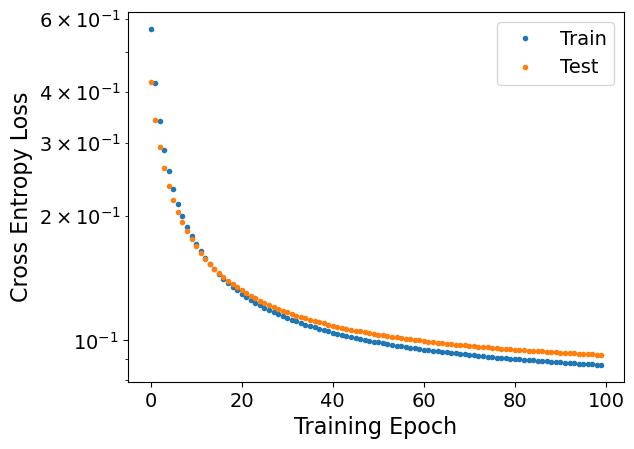

In [12]:
plt.plot(losses, '.', label="Train")
plt.plot(losses_test, '.', label="Test")
plt.legend()
plt.xlabel('Training Epoch')
plt.ylabel('Cross Entropy Loss')
plt.yscale('log');

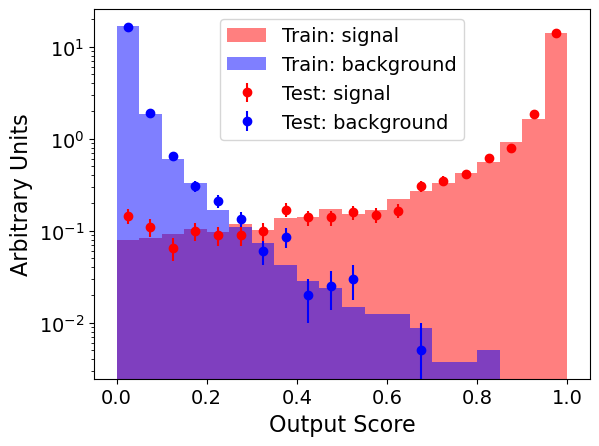

In [13]:
net.eval() # configure the model for evaluation (testing)
y_pred_test = net(x_test_tensor).detach().cpu()
y_pred_train= net(x_train_tensor).detach().cpu()

LCU.plot_classifier_output(y_train, y_pred_train, y_test, y_pred_test, nbins=20, range=(0,1))
plt.savefig("scores_FC_dummy.pdf")

/home/mhance/CABIN/LearningCutsUtils/Utils.py:28: RuntimeWarning: divide by zero encountered in scalar divide
  weight=1./(sum(counts)*(bin_edges[1]-bin_edges[0]))
/home/mhance/CABIN/LearningCutsUtils/Utils.py:29: RuntimeWarning: invalid value encountered in multiply
  counts = weight*counts
/home/mhance/CABIN/LearningCutsUtils/Utils.py:30: RuntimeWarning: invalid value encountered in multiply
  err = weight*err


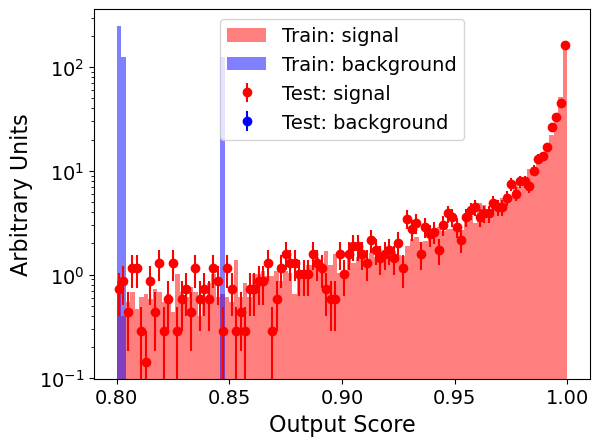

In [14]:
LCU.plot_classifier_output(y_train, y_pred_train, y_test, y_pred_test, nbins=100, range=(0.8,1))

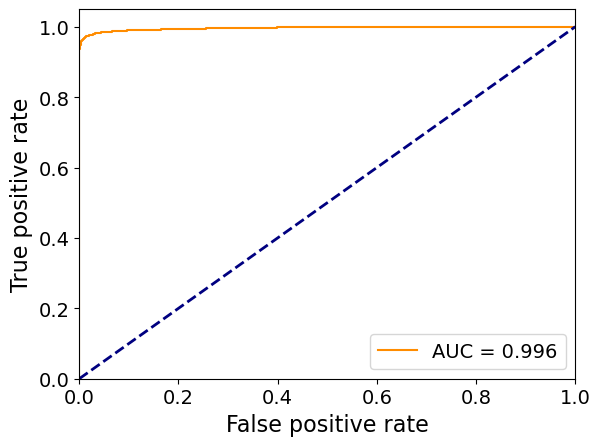

In [15]:
LCU.make_ROC_curve(y_test, y_pred_test)
plt.savefig("ROC_FC_dummy.pdf")

In [16]:
net[0].weight

Parameter containing:
tensor([[-0.4396,  0.5394,  1.1274,  1.4562,  0.2353,  0.5144, -0.8886,  0.0190,
         -2.1447,  0.5971]], requires_grad=True)

In [17]:
net[0].bias

In [18]:
if net[0].bias is not None:
    -net[0].bias/net[0].weight

    fig = plt.figure(figsize=(20,5))
    fig.tight_layout()
    nbins=50
    
    biases=net[0].bias.detach().numpy()
    weights=net[0].weight.detach().numpy()
    scaled_cuts=-biases/weights
    
    cuts=sc.inverse_transform(scaled_cuts)[0]
    
    for b in range(m):
        ax=fig.add_subplot(2,5,1+b)
        plt.subplots_adjust(hspace=0.3,wspace=0.5)
        plt.yscale('log')
        ax.hist(x_signal[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='red')
        ax.hist(x_backgr[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='blue')
        ax.set_xlabel(f"Feature {b}")
        ax.set_ylabel("Events/Bin")
        if weights[0][b] < 0:
            ax.axvline(x = cuts[b], color='g') # cut is "less than"
        else:
            ax.axvline(x = cuts[b], color='y') # cut is "greater than"

It's clear that this super-simple network does slightly better than the fully-connected network that I set up.  Not
significantly better, but noticeably.  I don't see an obvious reason for why, aside from noting that a number of signal events in the OneToOneLinear network trained with a BCE loss function have ~0 output scores, while that's not the case in this setup.  I suspect that has to do with taking the product of feature scores to derive the final discriminant, as opposed to the sum as in the simple linear network.  I don't think that's something that can change.

Will be interesting to see how this compares for the slepton/diboson dataset.

Overall I think this is still hanging together, and I can present a progression of NN's:
* Fully connected with BCE
* OneToOneLinear with BCE
* OneToOneLinear with custom losses

Do those all with nominal, and then vary the test data inputs within some uncertainties and check to see the results on signal efficiency and background rejection.  Then test on slepton/diboson.  That's a solid paper right there, I'd say, and can be the starting point for Scott/Earl using this for photons.

Here we test.

In [19]:
LCU.check_noisy_test_inputs(x_test_tensor, y_test_tensor, net, net[0].weight[0], 0.95)

Output threshold for 95.0% efficiency: 0.45429617166519165 gives 95.0%

Signal efficiency for nominal, output>0.45429617166519165: 0.9496761335326358
Signal efficiency for noisy  , output>0.45429617166519165: 0.9344793223716991

Backgr efficiency for nominal, output>0.45429617166519165: 0.0027596588058203713
Backgr efficiency for noisy  , output>0.45429617166519165: 0.007275464124435524

Output threshold for 95.0% efficiency if trained on noisy data: 0.35773739218711853 gives 95.0%
